# Tugas Sentiment Analysis

#### Dataset = https://www.kaggle.com/datasets/artamevia/twitter-dataset-covid-surabaya

- Rangga Aldo Sastrowardoyo - 5027211059
- Dzakirozaan Uzlahwasata - 5027211066

**Description** : Sentiment Analisis terkait data covid-19 yang bersumber dari twitter


### 1. Import Libraries


In [1]:
!pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.3 MB/s eta 0:00:00


In [2]:
!pip install wordcloud

In [3]:
!pip install scikeras

  Obtaining dependency information for scikeras from https://files.pythonhosted.org/packages/5d/fa/9c1967952e7889d698f10ba8b6af79dfaa2e05178d97a79fbd9d1b44e589/scikeras-0.12.0-py3-none-any.whl.metadata


In [4]:
import pandas as pd

pd.options.mode.chained_assignment = None
import numpy as np

seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

import nest_asyncio

nest_asyncio.apply()


import datetime as dt
import re

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [5]:
df = pd.read_csv("/kaggle/input/twitter-dataset-covid-surabaya/dataset_covidsurabaya_merged.csv", delimiter=",")


df.head()

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
0,Fri Oct 27 04:35:57 +0000 2023,1.717760e+18,"@caknuu 01/01/2020, pas malem lg di Bus Lorena...",0,1,0,0,in,1.279210e+18,1.717750e+18,IdMclaren,https://twitter.com/IdMclaren/status/171776203...
1,Wed Dec 21 23:06:46 +0000 2022,1.605700e+18,Pemeriksaan Covid19 Swab Test Antigen &amp PC...,0,0,1,1,in,1.049856e+09,1.605700e+18,sanderbiy7,https://twitter.com/sanderbiy7/status/16057013...
2,Mon Aug 01 09:47:53 +0000 2022,1.554040e+18,Satlantas Polrestabes Surabaya Melaksanakan hi...,0,0,0,0,in,1.448140e+18,1.554040e+18,satnarkoba_sby,https://twitter.com/satnarkoba_sby/status/1554...
3,Mon Aug 01 07:13:29 +0000 2022,1.554000e+18,Satlantas Polrestabes Surabaya Melaksanakan hi...,0,0,0,0,in,1.491620e+18,1.554000e+18,baglogtabessby,https://twitter.com/baglogtabessby/status/1554...
4,Mon Aug 01 06:54:22 +0000 2022,1.554000e+18,#Repost @jogosuroboyo • • • • • • Satlantas Po...,0,0,0,0,in,1.512430e+18,1.554000e+18,polsek_wiyung,https://twitter.com/polsek_wiyung/status/15539...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1725 entries, 0 to 1724
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   created_at           1725 non-null   object 
 1   id_str               1725 non-null   float64
 2   full_text            1725 non-null   object 
 3   quote_count          1725 non-null   int64  
 4   reply_count          1725 non-null   int64  
 5   retweet_count        1725 non-null   int64  
 6   favorite_count       1725 non-null   int64  
 7   lang                 1725 non-null   object 
 8   user_id_str          1725 non-null   float64
 9   conversation_id_str  1725 non-null   float64
 10  username             1725 non-null   object 
 11  tweet_url            1725 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 161.8+ KB


In [7]:
df.nunique()

created_at             1718
id_str                 1558
full_text              1717
quote_count              20
reply_count              24
retweet_count            36
favorite_count           61
lang                      1
user_id_str            1053
conversation_id_str    1541
username               1053
tweet_url              1719
dtype: int64

### 2. Data Preparation & EDA

- A. Data Formatting & Cleaning
- B. Text Length Cleaning

In [8]:
kolom_yang_dihapus = [
    "created_at",
    "id_str",
    "quote_count",
    "reply_count",
    "retweet_count",
    "favorite_count",
    "lang",
    "user_id_str",
    "conversation_id_str",
    "username",
    "tweet_url",
]


df = df.drop(kolom_yang_dihapus, axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1725 entries, 0 to 1724
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  1725 non-null   object
dtypes: object(1)
memory usage: 13.6+ KB


In [10]:
df.sample(5)

,full_text
1613,#BeritaJatim Jadwal dan Lokasi Vaksin Covid-1...
124,Corona sudah naik lagi surabaya #coronavirus #...
648,Update Virus Corona di Surabaya Hari ini 15 Ja...
249,vaksin Merah Putih adalah vaksin (Corona) yang...
1596,Min utk rute surabaya ke Jogjakarta apa masih ...


In [11]:
df.tail(5)

,full_text
1720,wanita tua yg trus mengemban amanah untuk men...
1721,Tad pas di test malah hasilnya positif -_- Ti...
1722,itu kemarin sarat muatan politik sebagai upa...
1723,GAWE EN MATAMU IKU PEMPROV NGAJOKNO SURAT GAW...
1724,heh surabaya sehari doang udah 300 org yg posi...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1725 entries, 0 to 1724
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  1725 non-null   object
dtypes: object(1)
memory usage: 13.6+ KB


In [13]:
# Cari indeks baris di mana kolom 'text' memiliki tipe data float
float_indices = df[df['full_text'].apply(lambda x: isinstance(x, float))].index

# Tampilkan baris dengan nilai float
print("Indeks baris dengan nilai float di kolom 'text':", float_indices)

# Opsional: Tampilkan data dari baris-baris tersebut
print(df.loc[float_indices])

Indeks baris dengan nilai float di kolom 'text': Index([], dtype='int64')
Empty DataFrame
Columns: [full_text]
Index: []


In [14]:
all_text = " ".join(tweet for tweet in df["full_text"])

wordcloud = WordCloud(background_color="white", width=800, height=400).generate(
    all_text
)

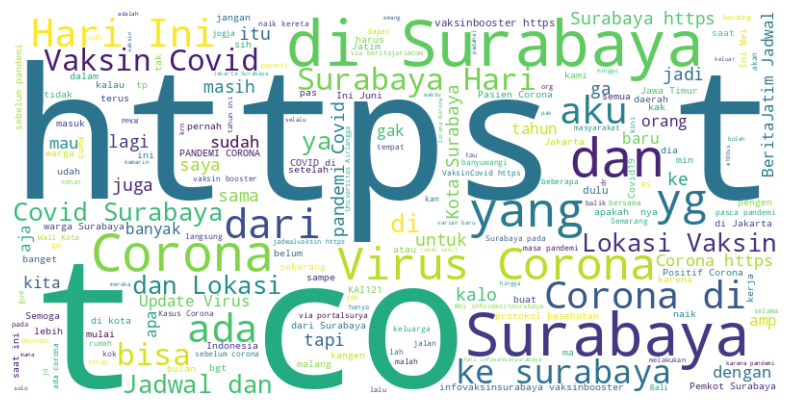

In [15]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Terlihat, masih raw data tersebut masih banyak yang kotor


#### A. Data Formatting & Cleaning


In [16]:
df.rename(columns={"full_text": "text"}, inplace=True)

In [17]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}


In [18]:
def cleaningText(text):
    text = re.sub(r"@[A-Za-z0-9]+", "", text)  # remove mentions
    text = re.sub(r"#[A-Za-z0-9]+", "", text)  # remove hashtag
    text = re.sub(r"RT[\s]", "", text)  # remove RT
    text = re.sub(r"http\S+", "", text)  # remove link
    text = re.sub(r"[0-9]+", "", text)  # remove numbers

    text = text.replace("\n", " ")  # replace new line into space
    text = text.translate(
        str.maketrans("", "", string.punctuation)
    )  # remove all punctuations
    text = text.strip(" ")  # remove characters space from both left and right text
    return text

def replaceEmojis(text):
    for emoji, meaning in emojis.items():
        text = text.replace(emoji, "EMOJI" + meaning)
    return text

def casefoldingText(text):  # Converting all the characters in a text into lower case
    text = text.lower()
    return text


def tokenizingText(
    text,
):  # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text


# Fungsi untuk memuat stopword dari file CSV
def load_stopwords(csv_filepath):
    df_stopwords = pd.read_csv(csv_filepath)
    return set(df_stopwords['ada'])  # Nama kolom dari stopword tersebut adalah "ada"

# Mengganti fungsi filteringText untuk menggunakan stopword dari file CSV
def filteringText(text, stopwords_set):
    filtered = [word for word in text if word not in stopwords_set]
    return filtered

# Jalur file ke stopword CSV (sesuaikan dengan lokasi file Anda)
csv_filepath = '/kaggle/input/indonesian-stoplist/stopwordbahasa.csv'

# Memuat stopword dari file CSV
listStopwords = load_stopwords(csv_filepath)

def stemmingText(
    text,
):  # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text


def toSentence(list_words):  # Convert list of words into sentence
    sentence = " ".join(word for word in list_words)
    return sentence

Teks Contoh:
"Halo dunia! Saya baru saja menonton berita di www.beritanews.com tentang teknologi terbaru. Menarik sekali! #Inovasi @BeritaUpdate"

1. cleaningText(text):
Fungsi ini membersihkan teks dari mentions, hashtags, RT, link, angka, baris baru, dan tanda baca.
Hasil: "Halo dunia Saya baru saja menonton berita di tentang teknologi terbaru Menarik sekali "

2. casefoldingText(text):
Mengubah semua karakter dalam teks menjadi huruf kecil.
Hasil: "halo dunia saya baru saja menonton berita di tentang teknologi terbaru menarik sekali "

3. tokenizingText(text):
Memecah teks menjadi daftar token/kata.
Hasil: ["halo", "dunia", "saya", "baru", "saja", "menonton", "berita", "di", "tentang", "teknologi", "terbaru", "menarik", "sekali"]

4. filteringText(text):
Menghilangkan stopwords dari teks.
Misalnya, jika "saya", "di", dan "sekali" adalah stopwords dalam bahasa Indonesia.
Hasil: ["halo", "dunia", "baru", "menonton", "berita", "tentang", "teknologi", "terbaru", "menarik"]

5. stemmingText(text):
Mengurangi setiap kata menjadi bentuk dasarnya.
Misalnya, "menonton" menjadi "tonton", "berita" menjadi "berit".
Hasil: ["halo", "dunia", "baru", "tonton", "berit", "tentang", "teknologi", "terbaru", "tarik"]

6. toSentence(list_words):
Mengonversi daftar kata menjadi kalimat.
Hasil: "halo dunia baru tonton berit tentang teknologi terbaru tarik"

In [19]:
# # Preprocessing df data
# df["text_clean"] = df["text"].apply(replaceEmojis)
# df["text_clean"] = df["text"].apply(cleaningText)
# df["text_clean"] = df["text_clean"].apply(casefoldingText)
# df.drop(["text"], axis=1, inplace=True)

# df["text_preprocessed"] = df["text_clean"].apply(tokenizingText)
# df["text_preprocessed"] = df["text_preprocessed"].apply(lambda x: filteringText(x, listStopwords))
# df["text_preprocessed"] = df["text_preprocessed"].apply(stemmingText)

# # drop duplicates/spams data
# df.drop_duplicates(subset="text_clean", inplace=True)

# df.head()

Cell Data Cleaning di atas menggunakan waktu yang cukup lama untuk jika anda memiliki dataset yang besar, sehingga kami melakukan nya terlebih dahulu lalu menyimpan cleaned dataset tersebut dalam bentuk csv sebagai berikut


In [20]:
# # Export to csv file
# df.to_csv(
#     r"merged_final.csv",
#     index=False,
#     header=True,
#     index_label=None,
# )

In [21]:
df.tail(10)

,text
1715,@Gagangs97596089 Selamat sore Kak. Mohon maaf ...
1716,@eldepeu Selamat siang Kak dan mohon maaf baru...
1717,"@KAI121 malam, mau tanya. Jika mau naik kereta..."
1718,Halo min @KAI121 distasiun surabaya gubeng saa...
1719,Gerai vaksin presisi Polsek Tegalsari Polresta...
1720,wanita tua yg trus mengemban amanah untuk men...
1721,Tad pas di test malah hasilnya positif -_- Ti...
1722,itu kemarin sarat muatan politik sebagai upa...
1723,GAWE EN MATAMU IKU PEMPROV NGAJOKNO SURAT GAW...
1724,heh surabaya sehari doang udah 300 org yg posi...


Di sini kami mengimport dataset kami yang sudah dipreprocessed


In [22]:
df = pd.read_csv("/kaggle/input/twitter-dataset-covid-surabaya/merged_final_.csv", delimiter=",")

df.tail()

,text_clean,text_preprocessed
1500,wanita tua yg trus mengemban amanah untuk menj...,"['wanita', 'tua', 'yg', 'trus', 'emban', 'aman..."
1501,tad pas di test malah hasilnya positif tiket ...,"['tad', 'pas', 'test', 'hasil', 'positif', 'ti..."
1502,itu kemarin sarat muatan politik sebagai upaya...,"['kemarin', 'sarat', 'muat', 'politik', 'upaya..."
1503,gawe en matamu iku pemprov ngajokno surat gawe...,"['gawe', 'en', 'mata', 'iku', 'pemprov', 'ngaj..."
1504,heh surabaya sehari doang udah org yg positif...,"['heh', 'surabaya', 'hari', 'doang', 'udah', '..."


In [23]:
def preprocess_text(text):
    if pd.isna(text):
        return []
    text = str(text)
    cleaned_text = (
        text.replace("'", "").replace(",", "").replace("]", "").replace("[", "")
    )
    words_list = cleaned_text.split()
    return words_list


df["text_preprocessed"] = df["text_preprocessed"].apply(preprocess_text)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1505 entries, 0 to 1504
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text_clean         1504 non-null   object
 1   text_preprocessed  1505 non-null   object
dtypes: object(2)
memory usage: 23.6+ KB


In [25]:
df['text_clean'] = df['text_clean'].fillna('')

In [26]:
all_text = " ".join(tweet for tweet in df["text_clean"])

wordcloud_preprocessed = WordCloud(
    background_color="white", width=800, height=400
).generate(all_text)

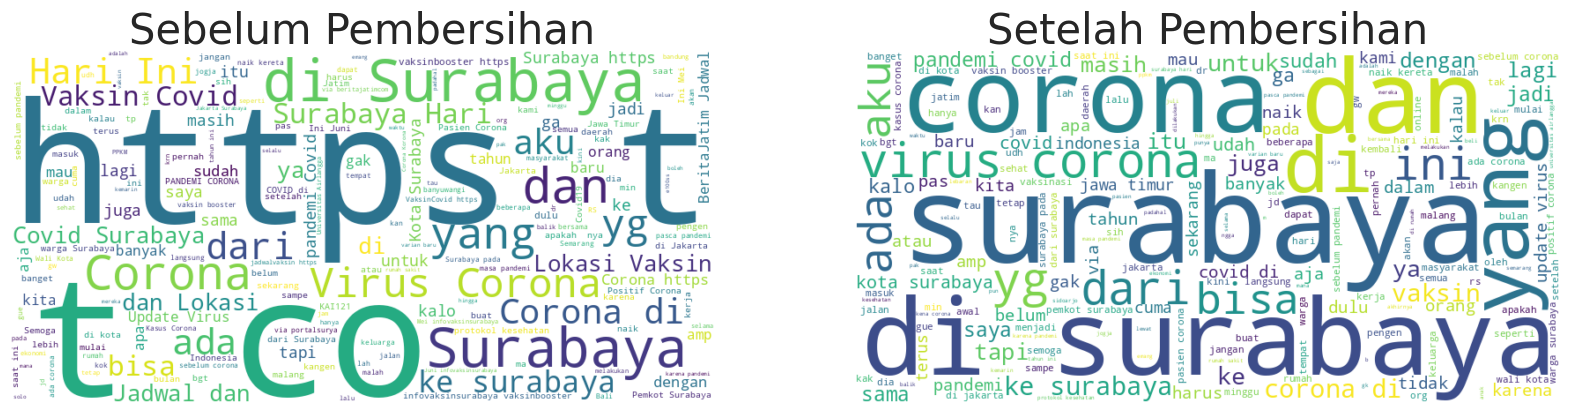

In [27]:
# Mengatur subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Tampilkan WordCloud sebelum pembersihan
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis("off")
ax1.set_title("Sebelum Pembersihan", fontsize=30)

# Tampilkan WordCloud setelah pembersihan
ax2.imshow(wordcloud_preprocessed, interpolation="bilinear")
ax2.axis("off")
ax2.set_title("Setelah Pembersihan", fontsize=30)  # Mengubah ukuran font menjadi 20
# Tampilkan plot
plt.show()

#### B. Text Length Cleaning


In [28]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [29]:
df["text_len"] = text_len

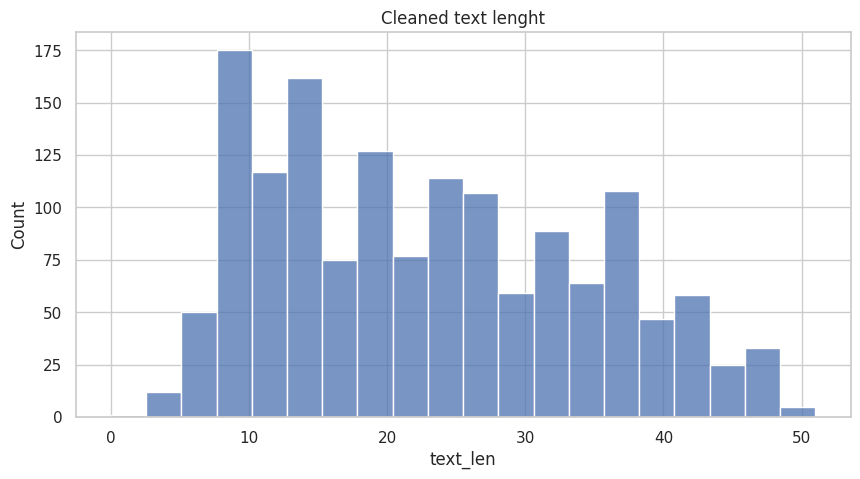

In [30]:
plt.figure(figsize=(10, 5))
sns.histplot(x="text_len", data=df, bins=20)
plt.title("Cleaned text lenght")
plt.show()

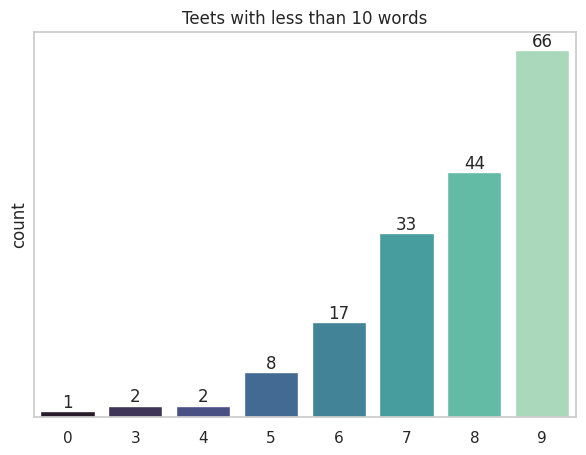

In [31]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(x="text_len", data=df[df["text_len"] < 10], palette="mako")
plt.title("Teets with less than 10 words")
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel("count")
plt.xlabel("")
plt.show()

In [32]:
df = df[df["text_len"] > 4]

Di sini, kami menghapus row data yang mempunayi (tweet length

### 3. Sentiment Analysis


Di sini kami memakai indonesian text sentiment yang berasal dari sumber berikut : https://github.com/fajri91/InSet


In [33]:
positive = pd.read_csv('/kaggle/input/indonesia-sentiment-analysis/positive.csv')

positive.head()

,word,weight
0,hai,3
1,merekam,2
2,ekstensif,3
3,paripurna,1
4,detail,2


In [34]:
try:
    negative = pd.read_csv('/kaggle/input/indonesia-sentiment-analysis/negative.csv')
except UnicodeDecodeError:
    negative = pd.read_csv('/kaggle/input/indonesia-sentiment-analysis/negative.csv', encoding='latin1')  # atau 'ISO-8859-1', 'cp1252'

negative.head()

,word,weight
0,putus tali gantung,-2
1,gelebah,-2
2,gobar hati,-2
3,tersentuh (perasaan),-1
4,isak,-5


In [35]:
import csv

lexicon_positive = dict()
with open("/kaggle/input/indonesia-sentiment-analysis/positive.csv", "r", encoding="ISO-8859-1") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    header = next(reader, None)
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
with open("/kaggle/input/indonesia-sentiment-analysis/negative.csv", "r", encoding="ISO-8859-1") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    header = next(reader, None)
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

# Function to determine sentiment polarity of df
def sentiment_analysis_lexicon_indonesia(text):
    # for word in text:
    score = 0
    for word in text:
        if word in lexicon_positive:
            score = score + lexicon_positive[word]
    for word in text:
        if word in lexicon_negative:
            score = score + lexicon_negative[word]
    polarity = ""
    if score > 0:
        polarity = "positive"
    elif score < 0:
        polarity = "negative"
    else:
        polarity = "neutral"
    return score, polarity

In [36]:
results = df["text_preprocessed"].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df["polarity_score"] = results[0]
df["polarity"] = results[1]
print(df["polarity"].value_counts())

polarity
negative    943
positive    425
neutral     132
Name: count, dtype: int64


In [37]:
df.sample(10)

,text_clean,text_preprocessed,text_len,polarity_score,polarity
541,dprd minta pemkot surabaya berikan dana stimul...,"[dprd, pemkot, surabaya, dana, stimulan, warga...",13,1,positive
668,udah gitu yg nyebelin wali kotanya sambil jadi...,"[udah, gitu, yg, nyebelin, wali, kota, mensos,...",31,-13,negative
504,aku juga pernah mak kejadiannya awal tahun lal...,"[mak, jadi, corona, simpang, diri, surabaya, p...",41,-13,negative
679,aku surabaya kalo twin cika sidoarjo jadi deke...,"[surabaya, kalo, twin, cika, sidoarjo, dekettt...",17,0,neutral
328,virus corona di surabaya juli aturan ppkm dar...,"[virus, corona, surabaya, juli, atur, ppkm, da...",14,-6,negative
208,kasus corona atau covid di wilayah jakarta dan...,"[corona, covid, wilayah, jakarta, surabaya, tu...",23,-5,negative
713,surabaya keknya ngga kekurangan mall kalo mo n...,"[surabaya, kek, ngga, kurang, mall, kalo, mo, ...",30,-19,negative
861,permen minyak kayu putih melayani grosir dan e...,"[permen, minyak, kayu, putih, layan, grosir, e...",26,-10,negative
471,video murid smp membuat sajadah anti corona me...,"[video, murid, smp, sajadah, anti, corona, sam...",32,12,positive
223,numpak bumel mulyo solo purwokerto mas ribu...,"[numpak, bumel, mulyo, solo, purwokerto, mas, ...",29,1,positive


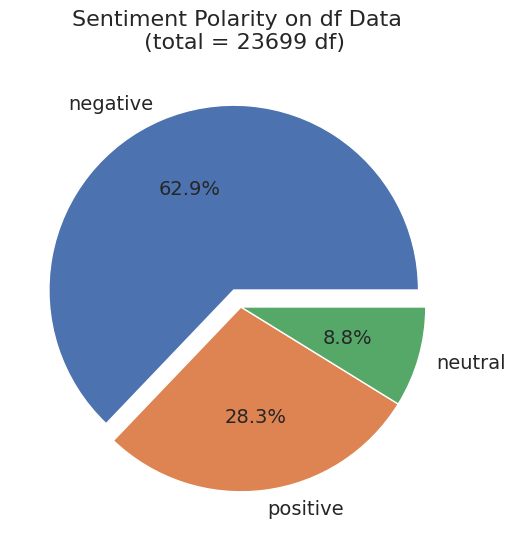

In [38]:
fig, ax = plt.subplots(figsize=(6, 6))
sizes = [count for count in df["polarity"].value_counts()]
labels = list(df["polarity"].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(
    x=sizes,
    labels=labels,
    autopct="%1.1f%%",
    explode=explode,
    textprops={"fontsize": 14},
)
ax.set_title("Sentiment Polarity on df Data \n (total = 23699 df)", fontsize=16, pad=20)
plt.show()

### Top 10 Positive and Negative Tweet Sentiments


#### Top 10 Positive Tweet Sentiments


In [39]:
pd.set_option("display.max_colwidth", 3000)
positive_df = df[df["polarity"] == "positive"]
positive_df = (
    positive_df[["text_clean", "polarity_score", "polarity"]]
    .sort_values(by="polarity_score", ascending=False)
    .reset_index(drop=True)
)
positive_df.index += 1
positive_df[0:10]

,text_clean,polarity_score,polarity
1,padahal masjidnya ditepi jln raya semarangsurabaya dan tentu banyak musafir dr beebagai daerah mampir kemasjid itu utk sholat jadi sy berfikirbetulkah ada itu virus corona krn kenyataannya jamaah masjid tersebut aman aman sj smg kita semua dilindungi oleh alloh dijaga oleh nya,21,positive
2,semangat pagi kawankawan warganet radio suara surabaya semoga hari ini selalu dalam kesehatan ini makanan rutin saya pagi sarapan sup daun kelor yg menurut ahli gizi mengandung banyak gizi baik untuk kesehatan saat corona selamat mencoba salam sehat,19,positive
3,hai sobat sehat ditjen kefarmasian amp alkes kemenkes melalui direktorat pengelolaan amp pelayanan kefarmasian menyelenggarakan pertemuan koordinasi pemantauan amp supervisi kualitas pengelolaan logistik dan persiapan switch ipv amp introduksi vaksin baru pada juni di surabaya,19,positive
4,tapi kalau dipikir alhamdulilah sebelum corona sempet lah ya keluar kota januari seminar plus jalan jalan di surabaya februari staycation sama magnae line nutrisionis maret ke surabaya sama batu in days round ya mari syukuri saja,19,positive
5,suroeboyoe tempoe doeloe salam warga surabaya salam sedoeloer kuabeh selamat berjuang kembali dalam pekerjaan setelah menikmati libur hari minggu bersama keluarga doa ku buat seluruh warga kota surabaya sehat selalu jaga keluarga dari virus corona jaga kesehatan,18,positive
6,selamat malam maaf kak belum tersedia kembali layanan vaksin di daerah operasi surabaya silakan dicoba datang ke sentra kesehatan lainnya yang menyediakan ya trims,17,positive
7,lahir di desa abah pas mulai tk ortu bikin rumah di desa asal ibu mepet rumah mbah mts mondok blitaraliyah mondok d pwa kediri kuliah di jkt makin jauh pulang kerja gasampe setahun di surabaya tb” corona terus nikah langsung ikut suami,17,positive
8,selamat malam maaf kak belum tersedia kembali layanan vaksin di daerah operasional surabaya silakan dicoba datang ke sentra kesehatan lainnya yang menyediakan ya trims,16,positive
9,tahun kerja di laksmi bikin bundlingan sama muamua kelas menengah di surabaya kalo make up akad harga segini normal kalo sama resepsi biasanya bisa jtan untuk make up aja 🤔 bisa makeup akad resepsi harga segini cuma pas pandemi aja tapi ada harga ada rupa cakeeep 🥳,16,positive
10,buat yang dom surabaya dan sekitarnya dan mau vaksin hpv tapi masih kurang informasi aku bersedia banget buat ditanyatanyain ya guys syarat sampai biayanya boleh banget kalau mau tanya ayo lindungi dan sayangi diri kalian,16,positive


#### Top 10 Negative Tweet Sentiments

In [40]:
pd.set_option("display.max_colwidth", 3000)
negative_tweets = df[df["polarity"] == "negative"]
negative_tweets = (
    negative_tweets[["text_clean", "polarity_score", "polarity"]]
    .sort_values(by="polarity_score", ascending=True)[0:10]
    .reset_index(drop=True)
)
negative_tweets.index += 1
negative_tweets[0:20]

,text_clean,polarity_score,polarity
1,goblok toh cok aku di jogja malah banyak yg kena corona satu desa tolol makanya toh bapak ibuk disuru pake masker ngeyel ae wes ngerti primitif tradisional saiki malah nulari ak harus pergi dr lingkungan sini di malang sm surabaya badanku sehat ae,-38,negative
2,sejak pandemi ini kak tau dari review di twitter amp review vlogger youtube cuma gak tau semua kapal atau beberapa aja yg aku tau juga sisa km kelud aja yg masih ada pilihan kelasnya ini contoh rute surabaya makassar kelasnya ditulis ekonomi semua,-34,negative
3,kalo mall kosong ya salahin pihak marketingnya anjir jangan konsumen teros yaa pasca pandemi di surabaya banyak kok beberapa mall yg bangkrut lalu dialih fungsikan menjadi lap basket lap badminton lap jogging tempat sepatu roda dll,-31,negative
4,mas saya memimpin rs di surabaya sudah tertib bayar pajak bahkan saat rugi di masa pandemi sisa bayar tapi malah dianggap kurang bayar tahun ini masih juga dipersoalkan pajak kami tahun tertiba pajak bukan diapresiasi tapi malah dirusuhi,-30,negative
5,seharusnya gatot nurmantiyo amp kami tau dirilah jangan ngotot memaksa diri disaat wabah covid menghantam surabaya pada umumnya indonesia berjuang melawan virus corona sampai tak kenal waktu bahkan sudah banyak rakyat korban serta para medis pemerintah harus bertindak tegas,-29,negative
6,wabah kematian hitam di masa lalu mewarisi penyakit hari ini surabaya – setelah pandemi covid melanda dunia banyak yang mencari tahu wabah apa saja yang pernah… via,-28,negative
7,umkm center di surabaya pada juli laludirektur utama bsi menegaskan umkm sebagai tulang punggung perekonomian indonesia perlu terus dikuatkan karena di tengah krisis akibat pandemi dan ancaman resesi global umkm akan sangat rentan dari sisi permodalan,-28,negative
8,sebuah percakapan naik ojol di surabaya bapak ojol oh dari malang saya malang juga mas tapi gak bisa mudik yaa tahun ini mas serba repot saya garagara corona sialan pak hehehe bo iya mas jancuk memang kita di kendaraan hahahahaha,-28,negative
9,wanine reply ngomong surabaya gak kenal corona ndasmu blok goblok kah deloken poo nang rumah sakit iki yoopo cok astaga utekmu melok mbok gae gule a,-25,negative
10,kanim tanjung perak surabaya sosialisasikan kebijakan izin tinggal baru 👇 kantor imigrasi kanim kelas i tpi tanjung perak menggelar acara diseminasi peraturan izin tinggal pasca pandemi dan golden… via,-25,negative


In [41]:
# Results from determine sentiment polarity of df

results = df["text_preprocessed"].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df["polarity_score"] = results[0]
df["polarity"] = results[1]
print(df["polarity"].value_counts())

# Export to csv file
df.to_csv(
    "polarity.csv",
    index=False,
    header=True,
    index_label=None,
)

df.head(10)

polarity
negative    943
positive    425
neutral     132
Name: count, dtype: int64


,text_clean,text_preprocessed,text_len,polarity_score,polarity
0,pas malem lg di bus lorena surabayajakarta turun di pool lorena lebak bulus badan panas batuk pusing sampe minggu gak sembuh mpe heran lama amat sembuhnya pas udah ke sininya baru nyadar kayaknya itu kena covid i got covid before it was popular,"[pas, malem, lg, bus, lorena, surabayajakarta, turun, pool, lorena, lebak, bulus, badan, panas, batuk, pusing, sampe, minggu, gak, sembuh, mpe, heran, sembuh, pas, udah, sini, nyadar, kayak, kena, covid, i, got, covid, before, it, was, popular]",43,-15,negative
1,pemeriksaan covid swab test antigen amp pcr rs phc surabaya,"[periksa, covid, swab, test, antigen, amp, pcr, rs, phc, surabaya]",10,-5,negative
2,satlantas polrestabes surabaya melaksanakan himbauan protokol kesehatan antisipasi meningkatnya covid di kota surabaya,"[satlantas, polrestabes, surabaya, laksana, himbauan, protokol, sehat, antisipasi, tingkat, covid, kota, surabaya]",13,5,positive
3,• • • • • • satlantas polrestabes surabaya melaksanakan himbauan protokol kesehatan antisipasi meningkatnya covid di kota surabaya,"[satlantas, polrestabes, surabaya, laksana, himbauan, protokol, sehat, antisipasi, tingkat, covid, kota, surabaya]",19,5,positive
4,satlantas polrestabes surabaya melaksanakan himbauan protokol kesehatan antisipasi meningkatnya covid di kota surabaya …lt titlegt,"[satlantas, polrestabes, surabaya, laksana, himbauan, protokol, sehat, antisipasi, tingkat, covid, kota, surabaya, lt, titlegt]",15,5,positive
5,jogosuroboyo di instagram satlantas polrestabes surabaya melaksanakan himbauan protokol kesehatan antisipasi meningkatnya covid di kota surabaya,"[jogosuroboyo, instagram, satlantas, polrestabes, surabaya, laksana, himbauan, protokol, sehat, antisipasi, tingkat, covid, kota, surabaya]",16,5,positive
6,reposted from lt titlegt di instagram satlantas polrestabes surabaya melaksanakan himbauan protokol kesehatan antisipasi meningkatnya covid di kota surabaya …lt titlegt,"[reposted, from, lt, titlegt, instagram, satlantas, polrestabes, surabaya, laksana, himbauan, protokol, sehat, antisipasi, tingkat, covid, kota, surabaya, lt, titlegt]",21,5,positive
7,with repost • • • • • • satlantas polrestabes surabaya melaksanakan himbauan protokol kesehatan antisipasi meningkatnya covid di kota surabaya,"[with, repost, satlantas, polrestabes, surabaya, laksana, himbauan, protokol, sehat, antisipasi, tingkat, covid, kota, surabaya]",21,5,positive
8,warga surabaya boleh pindahkan makam jenazah covid simak syaratnya surabaya – pemerintah kota surabaya kini memperbolehkan pemindahan makam covid pemindahan…,"[warga, surabaya, pindah, makam, jenazah, covid, simak, syarat, surabaya, perintah, kota, surabaya, boleh, pindah, makam, covid, pindah]",20,-11,negative
9,waspada peningkatan kasus penularan covid,"[waspada, tingkat, tular, covid]",5,-3,negative


In [42]:
# Function to group all positive/negative words
def words_with_sentiment(text):
    positive_words = []
    negative_words = []
    for word in text:
        score_pos = 0
        score_neg = 0
        if word in lexicon_positive:
            score_pos = lexicon_positive[word]
        if word in lexicon_negative:
            score_neg = lexicon_negative[word]

        if score_pos + score_neg > 0:
            positive_words.append(word)
        elif score_pos + score_neg < 0:
            negative_words.append(word)

    return positive_words, negative_words

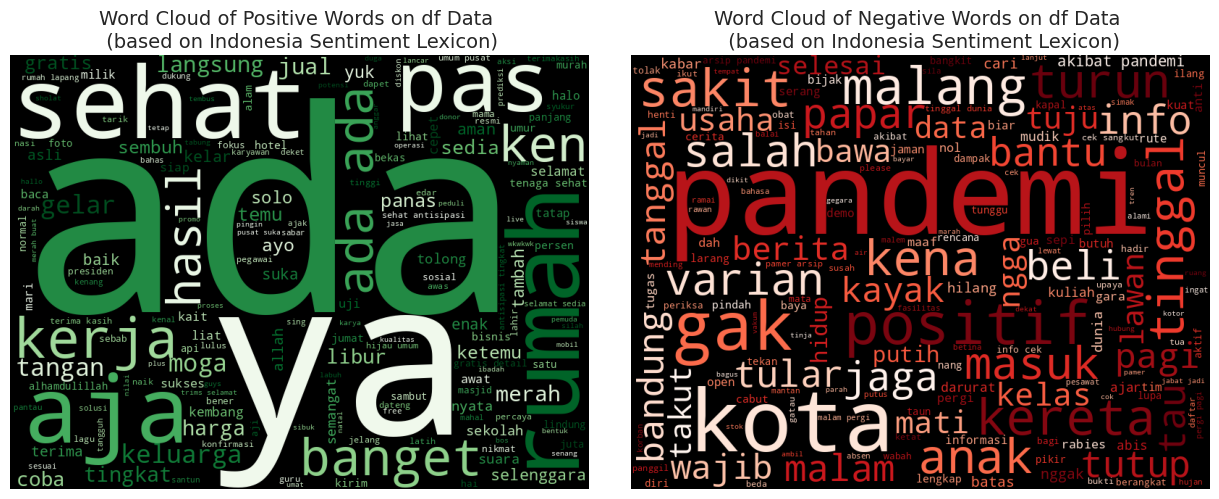

In [43]:
# Visualize positive and negative word cloud

sentiment_words = df["text_preprocessed"].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]

fig, ax = plt.subplots(1, 2, figsize=(12, 10))
list_words_postive = ""
for row_word in positive_words:
    for word in row_word:
        list_words_postive += " " + (word)
wordcloud_positive = WordCloud(
    width=800, height=600, background_color="black", colormap="Greens", min_font_size=10
).generate(list_words_postive)
ax[0].set_title(
    "Word Cloud of Positive Words on df Data \n (based on Indonesia Sentiment Lexicon)",
    fontsize=14,
)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis("off")

list_words_negative = ""
for row_word in negative_words:
    for word in row_word:
        list_words_negative += " " + (word)
wordcloud_negative = WordCloud(
    width=800, height=600, background_color="black", colormap="Reds", min_font_size=10
).generate(list_words_negative)
ax[1].set_title(
    "Word Cloud of Negative Words on df Data \n (based on Indonesia Sentiment Lexicon)",
    fontsize=14,
)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis("off")

plt.show()

In [44]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [45]:
dataframe = df.copy()

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 0 to 1504
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text_clean         1500 non-null   object
 1   text_preprocessed  1500 non-null   object
 2   text_len           1500 non-null   int64 
 3   polarity_score     1500 non-null   int64 
 4   polarity           1500 non-null   object
dtypes: int64(2), object(3)
memory usage: 70.3+ KB


In [46]:
kolom_yang_dihapus = [
   "text_preprocessed",
    "text_len",
    "polarity_score"
]


dataframe = dataframe.drop(kolom_yang_dihapus, axis=1)

In [47]:
text, sentiment = list(dataframe['text_clean']), list(dataframe['polarity'])

In [48]:
X_train, X_test, y_train, y_test = train_test_split(text, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  29758


In [50]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [51]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [52]:
results = None

try:
    BNBmodel = BernoulliNB(alpha = 2)
    BNBmodel.fit(X_train, y_train)
    y_pred = BNBmodel.predict(X_test)
    results = classification_report(y_test, y_pred)
except Exception as e:
    print(f"An error occurred during model fitting or evaluation: {e}")
finally:
    if results is not None:
        print("Model Evaluation Results:")
        print(results)
    else:
        print("No results to display.")

Model Evaluation Results:
              precision    recall  f1-score   support

    negative       0.54      1.00      0.70        40
     neutral       0.00      0.00      0.00         8
    positive       1.00      0.04      0.07        27

    accuracy                           0.55        75
   macro avg       0.51      0.35      0.26        75
weighted avg       0.65      0.55      0.40        75



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
results_svc = None

try:
    SVCmodel = LinearSVC()
    SVCmodel.fit(X_train, y_train)
    y_pred_svc = SVCmodel.predict(X_test)
    results_svc = classification_report(y_test, y_pred_svc)
except Exception as e:
    print(f"An error occurred during LinearSVC fitting or evaluation: {e}")
finally:
    if results_svc is not None:
        print("LinearSVC Model Evaluation Results:")
        print(results_svc)
    else:
        print("No results to display for LinearSVC.")


LinearSVC Model Evaluation Results:
              precision    recall  f1-score   support

    negative       0.67      0.93      0.78        40
     neutral       0.80      0.50      0.62         8
    positive       0.80      0.44      0.57        27

    accuracy                           0.71        75
   macro avg       0.76      0.62      0.66        75
weighted avg       0.73      0.71      0.69        75



In [54]:
results_lr = None

try:
    LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
    LRmodel.fit(X_train, y_train)
    y_pred_lr = LRmodel.predict(X_test)
    results_lr = classification_report(y_test, y_pred_lr)
except Exception as e:
    print(f"An error occurred during LogisticRegression fitting or evaluation: {e}")
finally:
    if results_lr is not None:
        print("LogisticRegression Model Evaluation Results:")
        print(results_lr)
    else:
        print("No results to display for LogisticRegression.")


LogisticRegression Model Evaluation Results:
              precision    recall  f1-score   support

    negative       0.59      0.95      0.73        40
     neutral       1.00      0.25      0.40         8
    positive       0.78      0.26      0.39        27

    accuracy                           0.63        75
   macro avg       0.79      0.49      0.51        75
weighted avg       0.70      0.63      0.57        75



In [55]:
import pickle

In [56]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

In [57]:
csv_filepath = '/kaggle/input/indonesian-stoplist/stopwordbahasa.csv'

In [58]:
def load_stopwords(csv_filepath):
    """
    Load stopwords from a CSV file.
    """
    df_stopwords = pd.read_csv(csv_filepath)
    # Assuming the file has one column with the name 'stopword'
    return set(df_stopwords['ada'].tolist())

In [59]:
def preprocess(text, csv_filepath):
    """
    Preprocess the input text: clean, case fold, tokenize, remove stopwords, and stem.
    """
    # Load stopwords from CSV
    stopwords_set = load_stopwords(csv_filepath)

    text = cleaningText(text)
    text = casefoldingText(text)
    tokens = tokenizingText(text)
    tokens = filteringText(tokens, stopwords_set)
    tokens = stemmingText(tokens)
    return ' '.join(tokens)  # Rejoin tokens into a single string

# Example usage
sample_text = "Contoh teks yang akan diproses."
processed_text = preprocess(sample_text, csv_filepath)
print(processed_text)

contoh teks proses


In [60]:
def load_model(filepath):
    """
    Load a model from the specified file path.
    """
    with open(filepath, 'rb') as file:
        return pickle.load(file)

In [61]:
vectoriser = load_model('vectoriser-ngram-(1,2).pickle')
LRmodel = load_model('Sentiment-LR.pickle')

# Preprocess teks yang akan diprediksi
texts = ["Alhamdulillah, keluarga saya di surabaya sudah sembuh dari penyakit covid, mari panjatkan doa"]
processed_texts = [preprocess(text, csv_filepath) for text in texts]
vectorised_texts = vectoriser.transform(processed_texts)

# Lakukan prediksi
predictions = LRmodel.predict(vectorised_texts)

# Tampilkan hasil
for text, pred in zip(texts, predictions):
    print(f"Text: {text}, Prediction: {pred}")

Text: Alhamdulillah, keluarga saya di surabaya sudah sembuh dari penyakit covid, mari panjatkan doa, Prediction: positive


In [62]:
new_texts = ["Pemkot kota surabaya kurang bisa berbenah, akibat nya persentase meninggal di kecamatan keputih sangat tinggi"]

# Preprocess the new texts
processed_new_texts = [preprocess(text, csv_filepath) for text in new_texts]
vectorised_new_texts = vectoriser.transform(processed_new_texts)

# Perform predictions on the new texts
new_predictions = LRmodel.predict(vectorised_new_texts)

# Display the results for the new texts
for text, pred in zip(new_texts, new_predictions):
    print(f"Text: {text}, Prediction: {pred}")


Text: Pemkot kota surabaya kurang bisa berbenah, akibat nya persentase meninggal di kecamatan keputih sangat tinggi, Prediction: negative
